In [501]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [502]:
def importImage(path):
    images = []
    folder_path = path
    file_names = os.listdir(folder_path)
    i = 0
    for file_name in file_names:
        i+=1
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        images.append(image)
        if i == 10 : break
    return images


In [503]:
imageRed = importImage("traffic_light_data/train/red")
imageYellow = importImage("traffic_light_data/train/yellow")
imageGreen = importImage("traffic_light_data/train/green")

In [504]:
def displayImage(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(10, 10, i+1)
        bgr_image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(bgr_image)
    plt.show()


In [505]:
def resizeImage(images):
    images_resize = []
    for image in images:
        image_resize = cv2.resize(image,(200,400))
        images_resize.append(image_resize)
    return images_resize

In [506]:
imageRed_resize = resizeImage(imageRed)
imageYellow_resize = resizeImage(imageYellow)
imageGreen_resize = resizeImage(imageGreen)

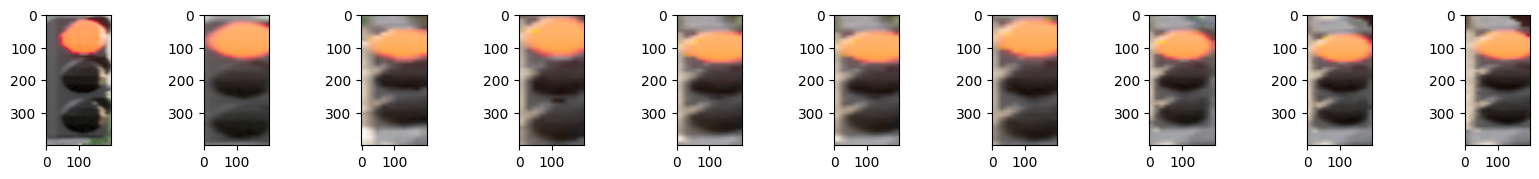

In [507]:
displayImage(imageRed_resize)

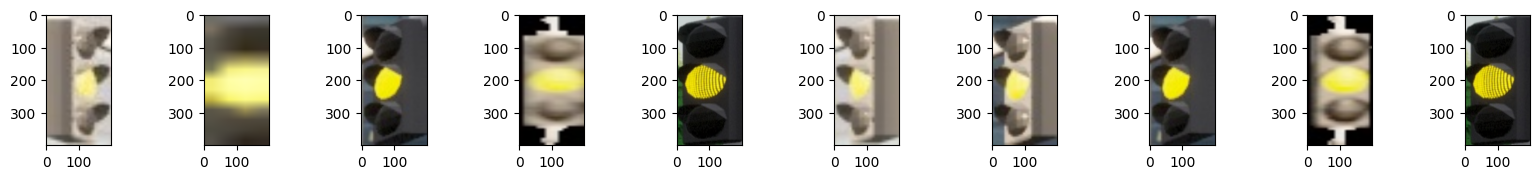

In [508]:
displayImage(imageYellow_resize)

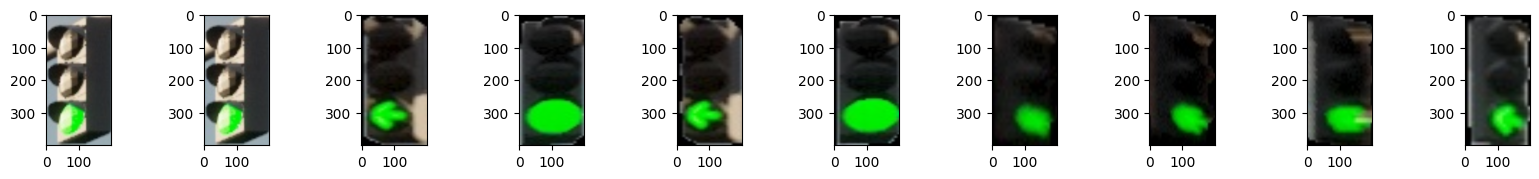

In [509]:
displayImage(imageGreen_resize)

In [510]:
def noiseRemoval(images):
    images_noise = []
    for image in images:
        image_noise = cv2.GaussianBlur(image, (5, 5), 0)
        images_noise.append(image_noise)
    return images_noise

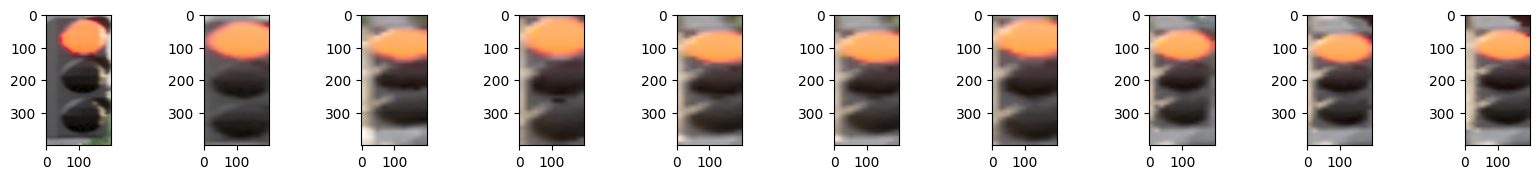

In [511]:
blurRed = noiseRemoval(imageRed_resize)
displayImage(blurRed)

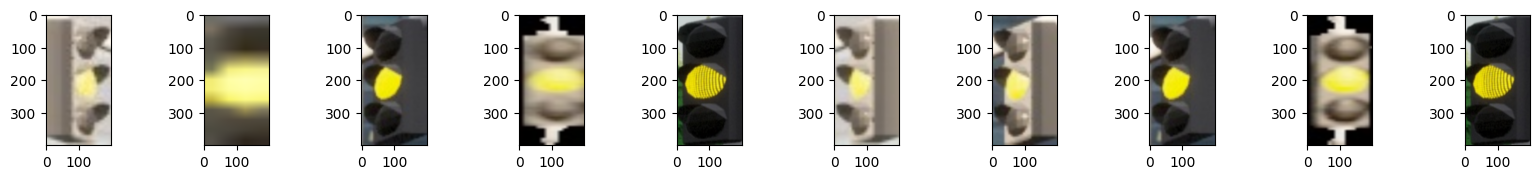

In [512]:
blurYellow = noiseRemoval(imageYellow_resize)
displayImage(blurYellow)

In [513]:
def contrastEnhancement(images):
    images_contrast = []
    for image in images:
        image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(image_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab_planes = list(lab_planes)
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab_planes = tuple(lab_planes)
        image_lab = cv2.merge(lab_planes)
        image_contrast = cv2.cvtColor(image_lab, cv2.COLOR_LAB2BGR)
        images_contrast.append(image_contrast)
    return images_contrast


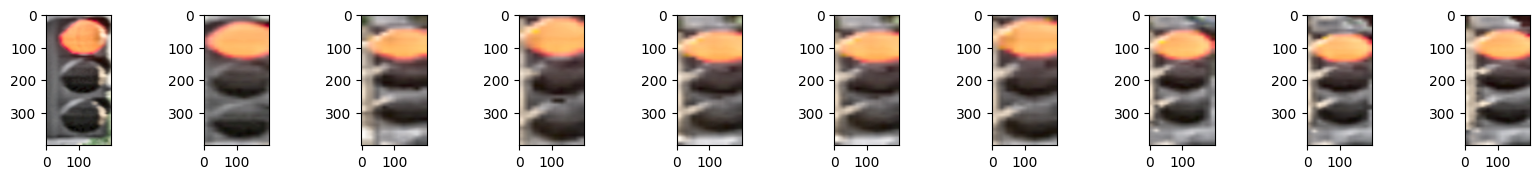

In [514]:
contrastRed = contrastEnhancement(blurRed)
displayImage(contrastRed)

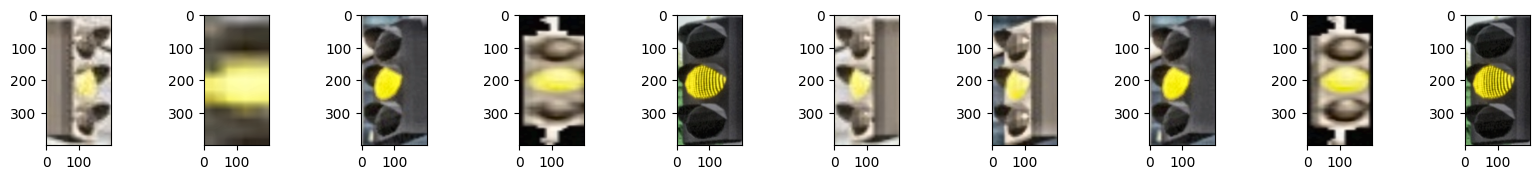

In [515]:
contrastYellow = contrastEnhancement(blurYellow)
displayImage(contrastYellow)

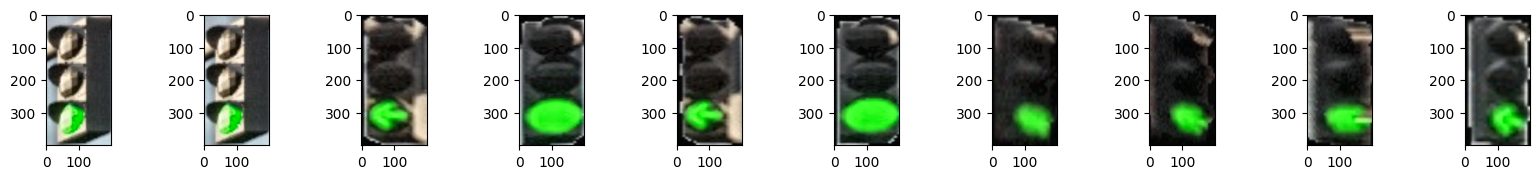

In [516]:
contrastGreen = contrastEnhancement(imageGreen_resize)
displayImage(contrastGreen)

In [517]:
def saturationEnhancement(images):
    images_saturation = []
    for image in images:
        image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        h, l, s = cv2.split(image_hls)
        saturation_factor = 1.5
        s = np.clip(s * saturation_factor, 0, 255).astype(np.uint8)
        image_hls = cv2.merge([h, l, s])
        image_saturated = cv2.cvtColor(image_hls, cv2.COLOR_HLS2BGR)
        images_saturation.append(image_saturated)
    return images_saturation


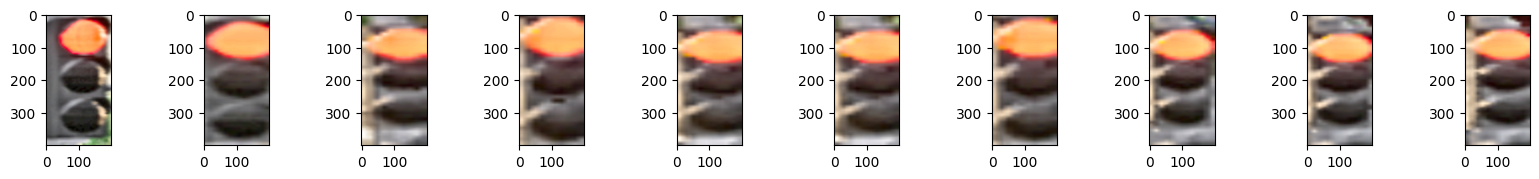

In [518]:
saturationRed = saturationEnhancement(contrastRed)
displayImage(saturationRed)

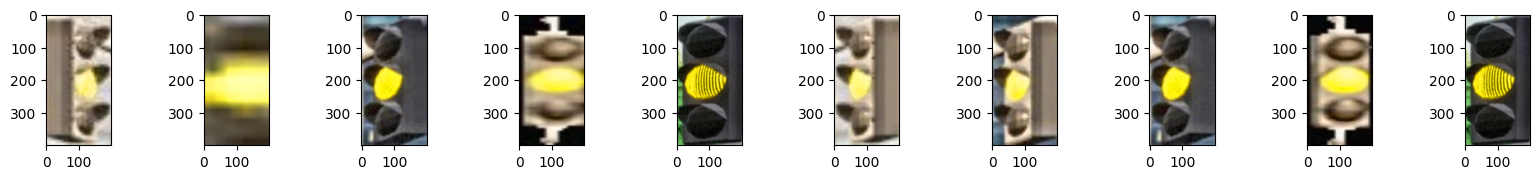

In [519]:
saturationYellow = saturationEnhancement(contrastYellow)
displayImage(saturationYellow)

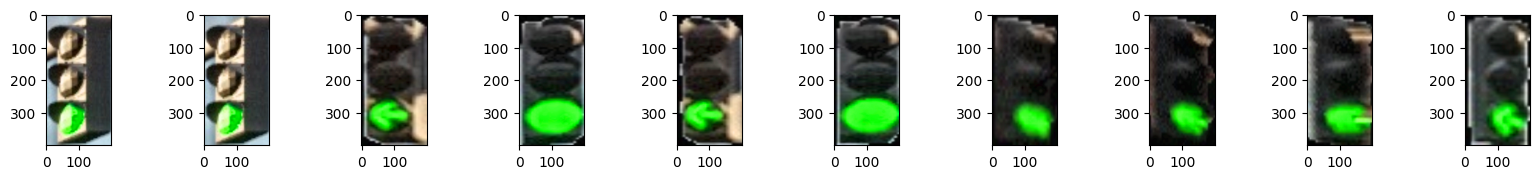

In [520]:
saturationGreen = saturationEnhancement(contrastGreen)
displayImage(saturationGreen)

In [521]:
def normalize(images):
    images_normalize = []
    for image in images:
        image_normalize = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        images_normalize.append(image_normalize)
    return images_normalize

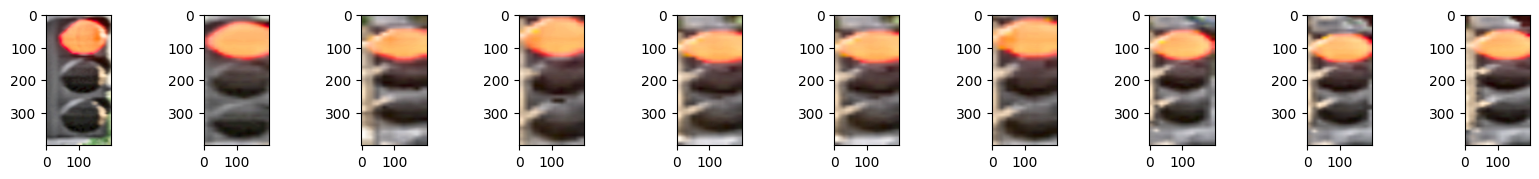

In [522]:
normalizeRed = normalize(saturationRed)
displayImage(normalizeRed)

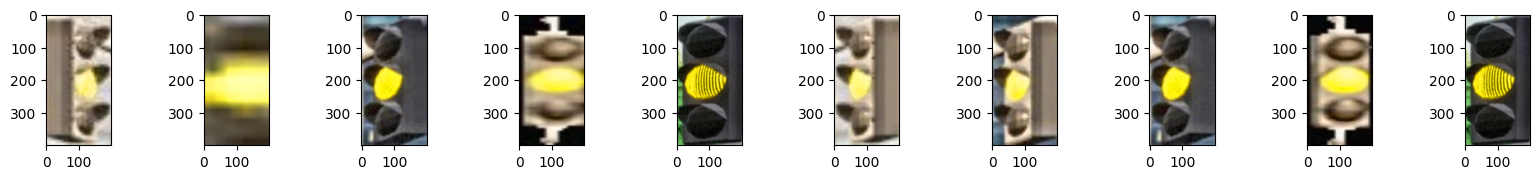

In [523]:
normalizeYellow = normalize(saturationYellow)
displayImage(normalizeYellow)

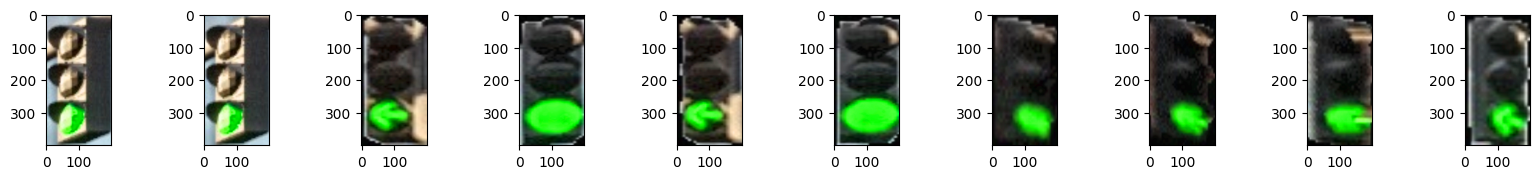

In [524]:
normalizeGreen = normalize(saturationGreen)
displayImage(normalizeGreen)

In [525]:
def edgeSegmentation(images):
    images_segmentasi = []
    for image in images:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        gradient_magnitude = np.uint8(gradient_magnitude)
        _, thresholded = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
        image_segmentasi = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR)
        image_segmentasi = cv2.dilate(image_segmentasi, np.ones((5, 5)), iterations=1)
        image_color = cv2.bitwise_and(image, image_segmentasi)

        images_segmentasi.append(image_color)

    return images_segmentasi


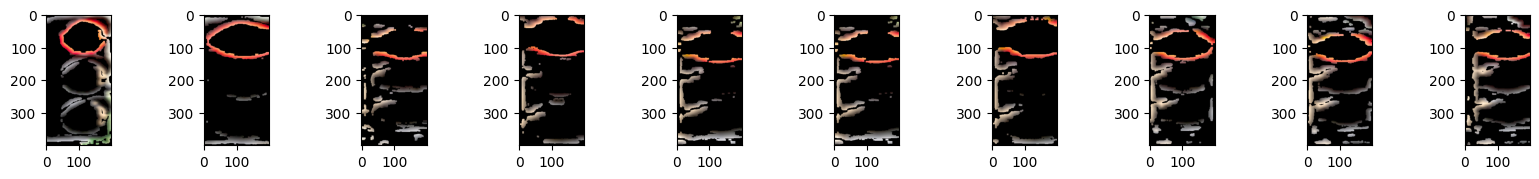

In [526]:
segmentasiRed = edgeSegmentation(normalizeRed)
displayImage(segmentasiRed)

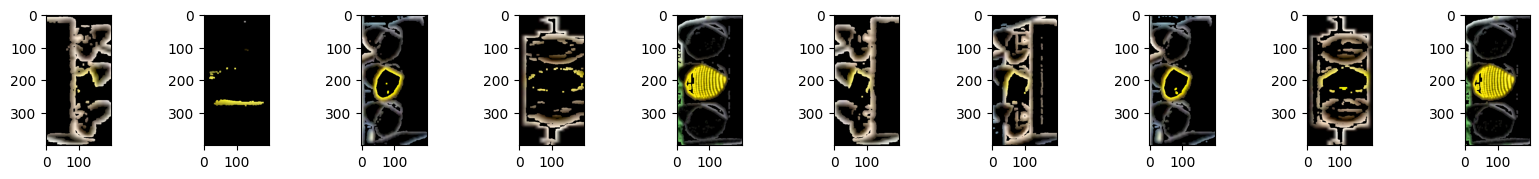

In [527]:
segmentasiYellow = edgeSegmentation(normalizeYellow)
displayImage(segmentasiYellow)

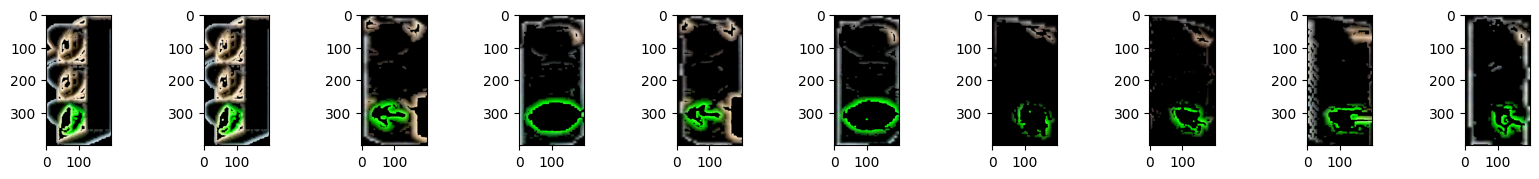

In [528]:
segmentasiGreen = edgeSegmentation(normalizeGreen)
displayImage(segmentasiGreen)

In [529]:
def removeSmallComponents(images_segmented):
    images_removed = []
    for image_segmented in images_segmented:
        image_gray = cv2.cvtColor(image_segmented, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(image_gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_area = 100
        filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
        mask = np.zeros_like(image_segmented)
        cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)
        image_removed = cv2.bitwise_and(image_segmented, mask)
        images_removed.append(image_removed)

    return images_removed


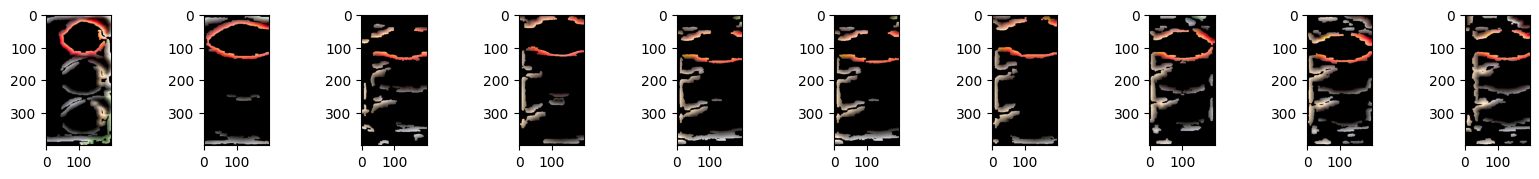

In [530]:
removedRed = removeSmallComponents(segmentasiRed)
displayImage(removedRed)

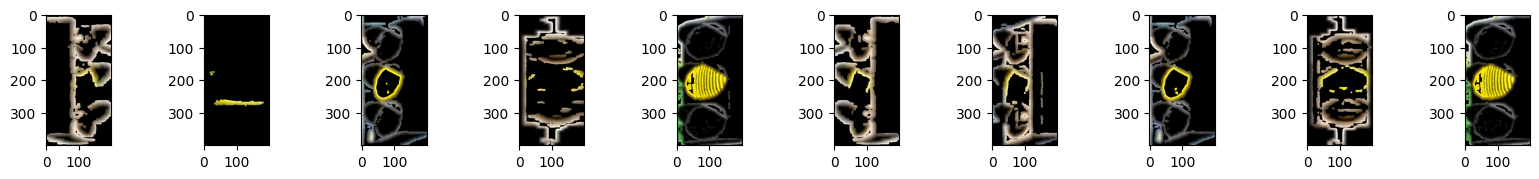

In [531]:
removedYellow = removeSmallComponents(segmentasiYellow)
displayImage(removedYellow)

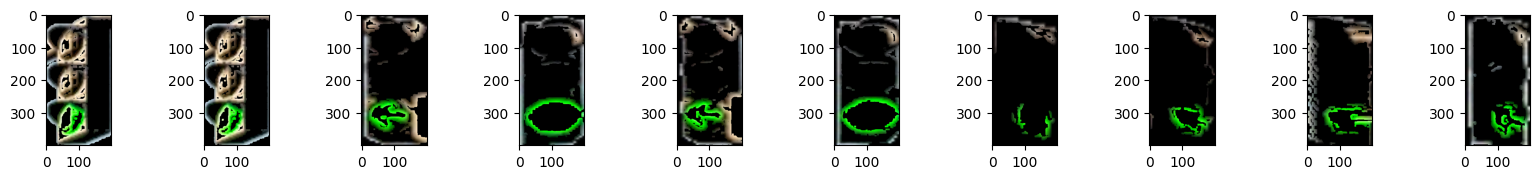

In [532]:
removedGreen = removeSmallComponents(segmentasiGreen)
displayImage(removedGreen)

In [533]:
def colorSegmentation(images):
    images_segmentasi = []
    for image in images:
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        lower_red = np.array([0, 100, 100])
        upper_red = np.array([10, 255, 255])
        lower_yellow = np.array([20, 100, 100])
        upper_yellow = np.array([30, 255, 255])
        lower_green = np.array([60, 100, 100])
        upper_green = np.array([80, 255, 255])
        
        mask_red = cv2.inRange(image_hsv, lower_red, upper_red)
        mask_yellow = cv2.inRange(image_hsv, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(image_hsv, lower_green, upper_green)
        
        mask = mask_red + mask_yellow + mask_green
        image_segmentasi = cv2.bitwise_and(image, image, mask=mask)
        images_segmentasi.append(image_segmentasi)
    
    return images_segmentasi


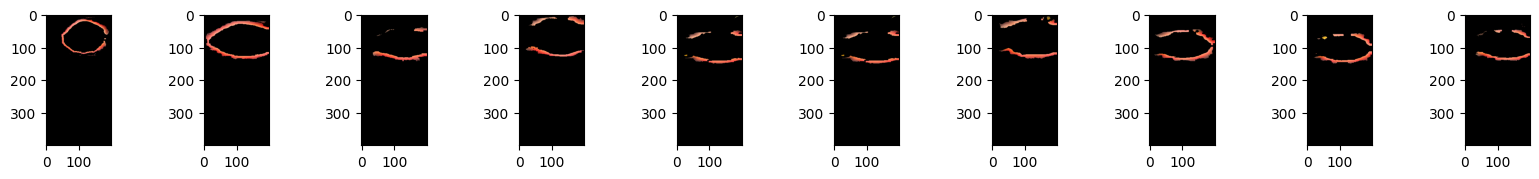

In [534]:
segmentasiRed = colorSegmentation(removedRed)
displayImage(segmentasiRed)

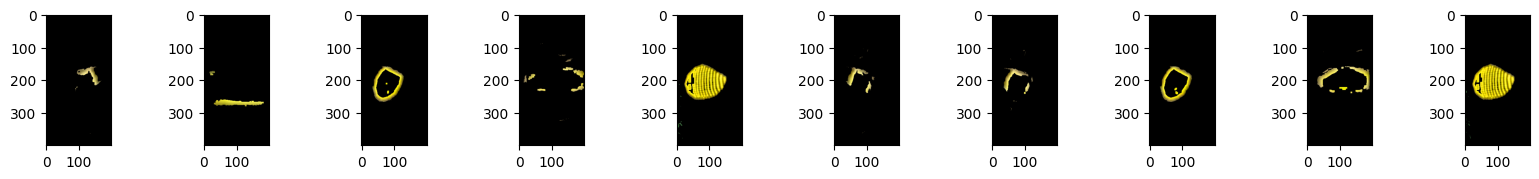

In [535]:
segmentasiYellow = colorSegmentation(removedYellow)
displayImage(segmentasiYellow)

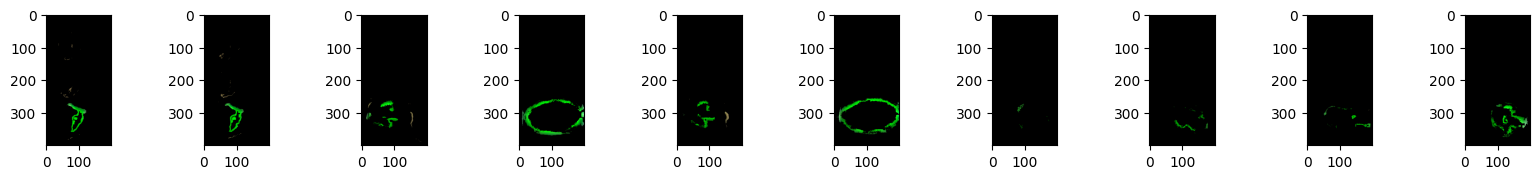

In [536]:
segmentasiGreen = colorSegmentation(removedGreen)
displayImage(segmentasiGreen)

In [537]:
def recognizeTrafficLightColor(red_images, yellow_images, green_images):
    labels = [0, 1, 2]

    features = []
    target_labels = []

    for image in red_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[0])

    for image in yellow_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[1])

    for image in green_images:
        avg_color = np.mean(image, axis=(0, 1))
        features.append(avg_color)
        target_labels.append(labels[2])

    X_train, X_test, y_train, y_test = train_test_split(features, target_labels, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)

    return model, scaler

In [538]:
model, scaler = recognizeTrafficLightColor(segmentasiRed, segmentasiYellow, segmentasiGreen)

In [539]:
def predictRandomTrafficLightColor(image, model, scaler):
    avg_color = np.mean(image, axis=(0, 1))
    scaled_color = scaler.transform([avg_color])
    predicted_label = model.predict(scaled_color)

    if predicted_label[0] == 0:
        return "Merah"
    elif predicted_label[0] == 1:
        return "Kuning"
    elif predicted_label[0] == 2:
        return "Hijau"

In [541]:
predicted_color = predictRandomTrafficLightColor(imageGreen[0], model, scaler)
print("Warna lampu lalu lintas: ", predicted_color)

Warna lampu lalu lintas:  Merah
